
   #  2D Kriging in Python for Engineers and Geoscientists 

## with GSLIB's KB2D Program Converted to Python

### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Kriging in Python with GSLIB's KB2D program translated to Python, wrappers and reimplementations of other GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

This exercise demonstrates the kriging method in Python with wrappers and reimplimentation of GSLIB methods. The steps include:

1. generate a 2D model with sequential Gaussian simulation
2. sample from the simulation
3. calculate and visualize the kriged map

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

I have also started to translate the GSLIB support subfunctions to Python. Stay tuned.

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.  Overtime, more of the GSLIB programs will be translated to Python and there will be no need to have the executables.  For this workflow you will need sgsim.exe from GSLIB.com for windows and Mac OS executables from https://github.com/GeostatsGuy/GSLIB_MacOS.  

I did this to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

This was my first effort to translate the GSLIB Fortran to Python.  It was pretty easy so I'll start translating other critical GSLIB functions.  I've completed NSCORE, DECLUS, GAM, GAMV and now KB2D as of now.

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with two utilities to load GSLIB's Geo-EAS from data files into DataFrames and 2D Numpy arrays.  These are used in the testing workflow.  

In [467]:
# Some GeostatsPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7.
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
# note, since I have now rewritten nscore, gam, gamv and kb2d one can just use these in Python
# available in the geostatspy package.
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods (version for subplots)
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods(version for subplots)
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods(version for subplots)
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev): 
    mean = np.average(array)
    stdev = np.std(array)  
    array = (tstdev/stdev)*(array - mean) + tmean
    return(array)   

def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var    

# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1

    sim_array = np.random.rand(nx,ny)

    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[iy,ix])
        y.append(yy[iy,ix])
        v.append(array[iy,ix])
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df) 

These are a variety of GSLIB subfunctions required by the GSLIB functions that I have converted to Python.  I will continue to convert the subfunctions and include them as needed by the GSLIB functions that I convert. All are available with geostatspy.

In [468]:
import math
import numpy as np
import numpy.linalg as linalg
from numba import jit

def dlocate(xx,iis,iie,x):
    from bisect import bisect
    n = len(xx)
    if iie <= iis:
        iis = 0; ie = n-1
    array = xx[iis:iie-1]  # this is accounting for swith to 0,...,n-1 index
    j = bisect(array,x)
    return j

def dsortem(ib,ie,a,iperm,b=0,c=0,d=0,e=0,f=0,g=0,h=0):
    a = a[ib:ie]
    inds = a.argsort()
    a = np.copy(a[inds]) # deepcopy forces pass to outside scope
    if(iperm == 1):
        return a
    b_slice = b[ib:ie]
    b = b_slice[inds]    
    if iperm == 2:
        return a,b
    c_slice = c[ib:ie]
    c = c_slice[inds]    
    if iperm == 3:
        return a, b, c
    d_slice = d[ib:ie]
    d = d_slice[inds]    
    if iperm == 4:
        return a, b, c, d
    e_slice = e[ib:ie]
    e = e_slice[inds]    
    if iperm == 5:
        return a, b, c, d, e 
    f_slice = f[ib:ie]
    f = f_slice[inds]
    if iperm == 6:
        return a, b, c, d, e, f 
    g_slice = g[ib:ie]
    g = g_slice[inds]
    if iperm == 7:
        return a, b, c, d, e, f, h     
    h_slice = h[ib:ie]
    h = h_slice[inds]
    return a, b, c, d, e, f, h

def gauinv(p):
    lim = 1.0e-10; p0 = -0.322232431088; p1 = -1.0; p2 = -0.342242088547
    p3 = -0.0204231210245; p4 = -0.0000453642210148; q0 = 0.0993484626060
    q1 = 0.588581570495; q2 = 0.531103462366; q3 = 0.103537752850; q4 = 0.0038560700634

# Check for an error situation:
    if p < lim:
        xp = -1.0e10
        return xp
    if p > (1.0-lim):
        xp =  1.0e10
        return xp    

# Get k for an error situation:
    pp = p
    if p > 0.5: pp = 1 - pp
    xp   = 0.0
    if p == 0.5: 
        return xp

# Approximate the function:
    y  = np.sqrt(np.log(1.0/(pp*pp)))
    xp = float(y + ((((y*p4+p3)*y+p2)*y+p1)*y+p0) /
            ((((y*q4+q3)*y+q2)*y+q1)*y+q0) )
    if float(p) == float(pp): 
        xp = -xp
    return xp

def gcum(x):
    z = x
    if z < 0:  
        z = -z
    t= 1./(1.+ 0.2316419*z)
    gcum = t*(0.31938153   + t*(-0.356563782 + t*(1.781477937 +
           t*(-1.821255978 + t*1.330274429))))
    e2= 0.0
    
# standard deviations out gets treated as infinity:
    if z <= 6: 
        e2 = np.exp(-z*z/2.0)*0.3989422803
    gcum = 1.0- e2 * gcum
    if x >= 0.0: 
        return gcum
    gcum = 1.0 - gcum
    return gcum

def dpowint(xlow,xhigh,ylow,yhigh,xval,pwr):
    EPSLON = 1.0e-20
    if (xhigh-xlow) < EPSLON:
        dpowint = (yhigh+ylow)/2.0
    else:
        dpowint = ylow + (yhigh-ylow)*(((xval-xlow)/(xhigh-xlow))**pwr)
    return dpowint

@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def setup_rotmat(c0,nst,it,cc,ang,PMX):
    DTOR=3.14159265/180.0; EPSLON=0.000000; PI=3.141593
# The first time around, re-initialize the cosine matrix for the
# variogram structures:
    rotmat = np.zeros((4,nst))
    maxcov = c0
    for js in range(0,nst):
        azmuth = (90.0-ang[js])*DTOR
        rotmat[0,js] =  math.cos(azmuth)
        rotmat[1,js] =  math.sin(azmuth)
        rotmat[2,js] = -1*math.sin(azmuth)
        rotmat[3,js] =  math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + PMX
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov
     
@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def cova2(x1,y1,x2,y2,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov):
    DTOR=3.14159265/180.0; EPSLON=0.000000; PI=3.141593
                      
# Check for very small distance:
    dx = x2-x1
    dy = y2-y1
#    print(dx,dy)
    if (dx*dx+dy*dy) < EPSLON:
        cova2 = maxcov
        return cova2

# Non-zero distance, loop over all the structures:
    cova2 = 0.0
    for js in range(0,nst):
#        print(js)
#        print(rotmat)
# Compute the appropriate structural distance:
        dx1 = (dx*rotmat[0,js] + dy*rotmat[1,js])
        dy1 = (dx*rotmat[2,js] + dy*rotmat[3,js])/anis[js]
        h   = math.sqrt(max((dx1*dx1+dy1*dy1),0.0))
        if it[js] == 1:

# Spherical model:
            hr = h/aa[js]
            if hr < 1.0: 
                cova2 = cova2 + cc[js]*(1.-hr*(1.5-.5*hr*hr))
            elif it[js] == 2:
                
# Exponential model:
                cova2 = cova2 + cc[js]*np.exp(-3.0*h/aa[js])
            elif it[js] == 3:

# Gaussian model:
                hh=-3.0*(h*h)/(aa[js]*aa[js])
                cova2 = cova2 +cc[js]*np.exp(hh)
            elif it[js] == 4:

# Power model:
                cov1  = PMX - cc[js]*(h**aa[js])
                cova2 = cova2 + cov1
            
    return cova2

def ksol_numpy(neq,a,r):
    #print('ksol python input')
    #print(a)
    a = a[0:neq*neq]           # trim the array
    a = np.reshape(a,(neq,neq))  # reshape to 2D
    #print('ksol python a reshape')
    #print(a)
    ainv = linalg.inv(a)       # invert matrix
    r = r[0:neq]               # trim the array
    s = np.matmul(ainv,r)                 # matrix multiplication
    return s

# this is incomplete - I'm considering removal since I now use the NumPy methods.
def ksol(nright,neq,nsb,a,r):
    s = np.zeros(len(r))

# If there is only one equation then set ising and return:
    if neq <= 1:
        ising = -1
        return s, ising
    
# Initialize:
    tol   = 0.1e-06
    ising = 0
    nn    = neq*(neq+1)/2
    nm    = nsb*neq
    m1    = neq-1
    kk    = 0

# Start triangulation:
    for k in range(0,m1):
        kk=kk+k
        ak=a[kk]
        if abs(ak) < tol:
            ising=k
            return s, ising
        km1=k-1
        for iv in range(0,nright):
            nm1=nm*(iv-1)
            ii=int(kk+nn*(iv-1))
            piv=1./a[ii]
            lp=0
            for i in range(k,m1):
                ll=ii
                ii=ii+i
                ap=a[ii]*piv
                lp=lp+1
                ij=ii-km1
                for j in range(i,m1):
                    ij=ij+j
                    ll=ll+j
                    a[ij]=a[ij]-ap*a[ll]
                for llb in range(k,nm,neq):
                    iin=llb+lp+nm1
                    ll1=llb+nm1
                    r[iin]=r[iin]-ap*r[ll1]

# Error checking - singular matrix:
    ijm=int(ij-nn*(nright-1))
    if abs(a[ijm]) < tol:
        ising=neq
        return s, ising

# Finished triangulation, start solving back:
    for iv in range(i,nright):
        nm1=nm*(iv-1)
        ij=int(ijm+nn*(iv-1))
        piv=1./a[ij]
        for llb in range(neq,nm,neq):
            ll1=llb+nm1
            s[ll1]=r[ll1]*piv
        i=neq
        kk=ij
        for ii in range(1,m1):
            kk=kk-i
            piv=1./a[kk]
            i=i-1
            for llb in range(i,nm,neq):     
                ll1=llb+nm1
                iin=ll1
                ap=r[iin]
                ij=kk
                for j in range(i,m1):
                    ij=ij+j
                    iin=iin+1
                    ap=ap-a[ij]*s[iin]

                s[ll1]=ap*piv

# Finished solving back, return:
    return s, ising



Here's the KB2D program translated to Python. I have applied Numba to speedup the covariance calculaiton.  I will look for additional speedups over time.  100 x 100 grid mesh will krige in about 10 seconds with 50 max data per estimate of 200 data in total on a modern desktop.

In [438]:
import math                       # for trig and constants
from numba import jit             # for precompile speed up 
# GSLIB's KB2D program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# translated by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)

def kb2d(df,xcol,ycol,vcol,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario): 
# Constants
    UNEST = -999.
    EPSLON = 1.0e-10
    VERSION = 2.907
    first = True
    PMX = 9999.0    
    MAXSAM = ndmax + 1
    MAXDIS = nxdis * nydis
    MAXKD = MAXSAM + 1
    MAXKRG = MAXKD * MAXKD
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Allocate the needed memory:   
    xdb = np.zeros(MAXDIS)
    ydb = np.zeros(MAXDIS)
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXKD)
    rr = np.zeros(MAXKD)
    s = np.zeros(MAXKD)
    a = np.zeros(MAXKRG)
    kmap = np.zeros((nx,ny))
    vmap = np.zeros((nx,ny))

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values

# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()

# Set up the discretization points per block.  Figure out how many
# are needed, the spacing, and fill the xdb and ydb arrays with the
# offsets relative to the block center (this only gets done once):
    ndb  = nxdis * nydis
    if ndb > MAXDIS: 
        print('ERROR KB2D: Too many discretization points ')
        print('            Increase MAXDIS or lower n[xy]dis')
        return kmap
    xdis = xsiz  / max(float(nxdis),1.0)
    ydis = ysiz  / max(float(nydis),1.0)
    xloc = -0.5*(xsiz+xdis)
    i    = -1   # accounting for 0 as lowest index
    for ix in range(0,nxdis):       
        xloc = xloc + xdis
        yloc = -0.5*(ysiz+ydis)
        for iy in range(0,nydis): 
            yloc = yloc + ydis
            i = i+1
            xdb[i] = xloc
            ydb[i] = yloc

# Initialize accumulators:
    cbb  = 0.0
    rad2 = radius*radius

# Calculate Block Covariance. Check for point kriging.
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    cov = cova2(xdb[0],ydb[0],xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
# Keep this value to use for the unbiasedness constraint:
    unbias = cov
    first  = False
    if ndb <= 1:
        cbb = cov
    else:
        for i in range(0,ndb): 
            for j in range(0,ndb): 
                cov = cova2(xdb[i],ydb[i],xdb[j],ydb[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
            if i == j: 
                cov = cov - c0
            cbb = cbb + cov
        cbb = cbb/real(ndb*ndb)

# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0,ny):
        yloc = ymn + (iy-0)*ysiz  
        for ix in range(0,nx):
            xloc = xmn + (ix-0)*xsiz

# Find the nearest samples within each octant: First initialize
# the counter arrays:
            na = -1   # accounting for 0 as first index
            dist.fill(1.0e+20)
            nums.fill(-1)

# Scan all the samples (this is inefficient and the user with lots of
# data should move to ktb3d):
            for iid in range(0,nd): # this was line 6 
                dx = x[iid] - xloc
                dy = y[iid] - yloc
                h2 = dx*dx + dy*dy
                #print(h2,rad2)
                if h2 <= rad2:
                    if (na < ndmax) or (h2 <= dist[na]):

# Consider this sample (it will be added in the correct location):
                        if na < ndmax: 
                            na = na + 1
                        nums[na] = iid
                        dist[na] = h2
                        if na > 1:
                            
# Sort samples found thus far in increasing order of distance:
                            n1 = na-1
                            for ii in range(0,n1+1):
                                k=ii
                                if h2 < dist[ii]:
                                    jk = 0
                                    for jj in range(k,n1+1):
                                        j  = n1-jk
                                        jk = jk+1
                                        j1 = j+1
                                        dist[j1] = dist[j]
                                        nums[j1] = nums[j]
                                    dist[k] = h2
                                    nums[k] = iid
                                    break # return to line 6, exit ii loop

# Is there enough samples?
            if na + 1 < ndmin:   # accounting for min index of 0
                est  = UNEST
                estv = UNEST
                print('UNEST at ' + str(ix) + ',' + str(iy))
            else:

# Put coordinates and values of neighborhood samples into xa,ya,vra:
                for ia in range(0,na+1):
                    jj = int(nums[ia])
                    xa[ia]  = x[jj]
                    ya[ia]  = y[jj]
                    vra[ia] = vr[jj]
                    
# Handle the situation of only one sample:
                if na == 0:  # accounting for min index of 0 - one sample case na = 0
                    cb1 = cova2(xa[0],ya[0],xa[0],ya[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    xx  = xa[0] - xloc
                    yy  = ya[0] - yloc

# Establish Right Hand Side Covariance:
                    if ndb <= 1:
                        cb = cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    else:
                        cb  = 0.0
                        for i in range(0,ndb):                  
                            cb = cb + cova2(xx,yy,xdb[i],ydb[i],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                            dx = xx - xdb(i)
                            dy = yy - ydb(i)
                            if (dx*dx+dy*dy) < EPSLON:
                                cb = cb - c0
                            cb = cb / real(ndb)
                    if ktype == 0:
                        s[0] = cb/cbb
                        est  = s[0]*vra[0] + (1.0-s[0])*skmean
                        estv = cbb - s[0] * cb
                    else:
                        est  = vra[0]
                        estv = cbb - 2.0*cb + cb1
                else:

# Solve the Kriging System with more than one sample:
                    neq = na + 1 + ktype # accounting for first index of 0
                    nn  = (neq + 1)*neq/2

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na+1):

# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na+1):  # was j - want full matrix                    
                            iin = iin + 1
                            a[iin] = cova2(xa[i],ya[i],xa[j],ya[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                        xx = xa[j] - xloc
                        yy = ya[j] - yloc

# Establish Right Hand Side Covariance:
                        if ndb <= 1:
                            cb = cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                        else:
                            cb  = 0.0
                            for j1 in range(0,ndb):    
                                cb = cb + cova2(xx,yy,xdb[j1],ydb[j1],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                                dx = xx - xdb[j1]
                                dy = yy - ydb[j1]
                                if (dx*dx+dy*dy) < EPSLON:
                                    cb = cb - c0
                            cb = cb / real(ndb)
                        r[j]  = cb
                        rr[j] = r[j]

# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na+1):
                            iin = iin + 1
                            a[iin] = unbias
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq]  = unbias
                        rr[neq] = r[neq]

# Solve the Kriging System:
                    s = ksol_numpy(neq,a,r)
                    ising = 0 # need to figure this out

# Write a warning if the matrix is singular:
                    if ising != 0:
                        print('WARNING KB2D: singular matrix')
                        print('              for block' + str(ix) + ',' + str(iy)+ ' ')
                        est  = UNEST
                        estv = UNEST
                    else:

# Compute the estimate and the kriging variance:
                        est  = 0.0
                        estv = cbb
                        sumw = 0.0
                        if ktype == 1: 
                            estv = estv - real(s[na+1])*unbias
                        for i in range(0,na+1):                          
                            sumw = sumw + s[i]
                            est  = est  + s[i]*vra[i]
                            estv = estv - s[i]*rr[i]
                        if ktype == 0: 
                            est = est + (1.0-sumw)*skmean
            kmap[ny-iy-1,ix] = est
            vmap[ny-iy-1,ix] = estv
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est*est

# END OF MAIN LOOP OVER ALL THE BLOCKS:

    if nk >= 1:
        ak = ak / float(nk)
        vk = vk/float(nk) - ak*ak
        print('  Estimated   ' + str(nk) + ' blocks ')
        print('      average   ' + str(ak) + '  variance  ' + str(vk))

    return kmap, vmap


Here's a simple test of the KB2D code with visualizations to check the results including the data, estimates and kriging variance plotted.  

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [ ]:
os.chdir("c:/PGE337")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Make a Simple, Small Example

The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then simply assume some data, and a variogram model.

This will allow for very fast iteration with the kB2D program.

In [470]:
import pandas as pd
nx = 100; ny = 100; xsiz = .05; ysiz = .05; xmn = 0.5; ymn = 0.5; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 3; ktype = 0; skmean = 2
vario = make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,hmaj1=0.6,hmin1=.2)
tmin = -999; tmax = 999
x = [5,4,2,1,1,3,5,2]; y = [1,2,2,3,4,4,2,3]; vr = [1,3,0,1,2.5,1.0,1.3,1.2]
df = pd.DataFrame({'x':x,'y':y,'vr':vr})

kmap, vmap = kb2d(df,'x','y','vr',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario)

  Estimated   10000 blocks 
      average   1.984891698010888  variance  0.01224913076801526


Let's visualize the resulting kriging estimates with the data plotted and the kriging variance map.

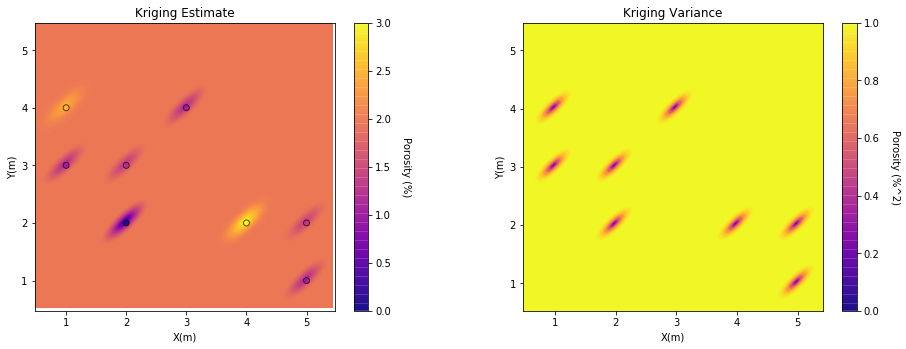

In [472]:
xmin = xmn - xsiz/2; ymin = ymn - ysiz/2;
xmax = xmin + xsiz * nx; ymax = ymin + ysiz * ny

plt.subplot(121)
locpix_st(kmap,xmin,xmax,ymin,ymax,xsiz,0.0,3.0,df,'x','y','vr','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
pixelplt_st(vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3)
plt.show()

##### Make a 2D Spatial Model to Sample Spaital Data

The following are the parameters for the next demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then we make a single realization of a Gausian distributed feature over the specified 2D grid and then apply affine correction to ensure we have a reasonable mean and spread for our feature's distribution, assumed to be Porosity (e.g. no negative values) while retaining the Gaussian distribution.  Any transform could be applied at this point.  We are keeping this workflow simple. *This is our truth model that we will sample*.

The parameters of *GSLIB_sgsim_2d_uncond* are (nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file).  nreal is the number of realizations, nx and ny are the number of cells in x and y, hsiz is the cell siz, seed is the random number seed, hrange and hrange2 are the variogram ranges in major and minor directions respectively, azi is the azimuth of the primary direction of continuity (0 is aligned with Y axis) and output_file is a GEO_DAS file with the simulated realization.  The ouput is the 2D numpy array of the simulation along with the name of the property.

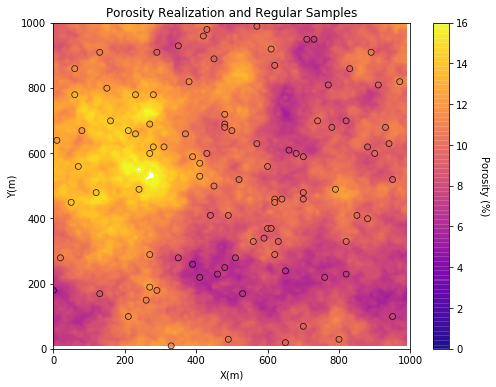

In [473]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 74073                                                     # random number seed  for stochastic simulation    
vario = make_variogram(0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500)
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 0; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# calculate a stochastic realization with standard normal distribution
sim = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,vario,"Por")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
sampling_ncell = 10                                              # sample every 10th node from the model
#samples = regular_sample(sim,xmin,xmax,ymin,ymax,sampling_ncell,30,30,'Realization')
#samples_cluster = samples.drop([80,79,78,73,72,71,70,65,64,63,61,57,56,54,53,47,45,42]) # this removes specific rows (samples)
#samples_cluster = samples_cluster.reset_index(drop=True)         # we reset and remove the index (it is not sequential anymore)
samples = random_sample(sim,xmin,xmax,ymin,ymax,cell_size,100,"Por")
locpix(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,samples,'X','Y','Por','Porosity Realization and Regular Samples','X(m)','Y(m)','Porosity (%)',cmap,"Por_Samples")

Below we assume a variogram and calculate a kriged map with the same grid as the simulation and conditional to the sampled values. Note: we are not concerned about the variogram of the kriging being consistent with the variogram of the data. We are exploring! This specific run took about 15 seconds on my desktop.

In [478]:
import pandas as pd
xsiz = cell_size; ysiz = cell_size; 
xmn = cell_size*0.5; ymn = cell_size*0.5; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 30; radius = 1000; ktype = 0; skmean = 10.0
vario = make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,hmaj1=100,hmin1=100)
tmin = -999; tmax = 999

kmap, vmap = kb2d(samples,'X','Y','Por',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario)

  Estimated   10000 blocks 
      average   10.106647972991999  variance  0.9754457076829652


Let's visualize the resulting kriging estimates with the data plotted and the kriging variance map.

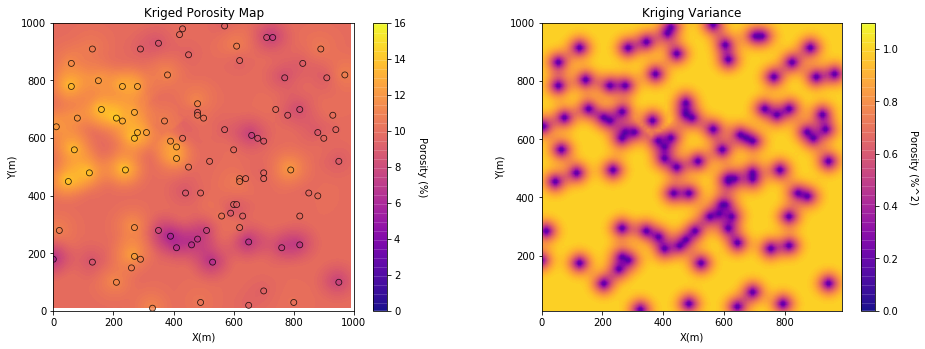

In [479]:
plt.subplot(121)
locpix_st(kmap,xmin,xmax,ymin,ymax,xsiz,vmin,vmax,samples,'X','Y','Por','Kriged Porosity Map','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
pixelplt_st(vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.1,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3)
plt.show()

I hope you find this code and demonstration useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

**Michael Pyrcz**, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On Twitter I'm the **GeostatsGuy** and on YouTube my lectures are on the channel, **GeostatsGuy Lectures**.